## Imports

In [21]:
import librosa
import numpy as np
import numpy.fft as fft
import os
import sys

from ipywidgets import interact_manual, FloatSlider
from matplotlib import pyplot as plt

from pyroomasync.settings import SPEED_OF_SOUND
from pyroomasync.room import ConnectedShoeBox
from pyroomasync.simulator import simulate
from scipy.signal.signaltools import correlate, correlation_lags

sys.path.append("..")
import tdoa
from tdoa.tdoa import compute_correlations
from datasets.math_utils import compute_distance

from tdoa.visualization import plot_mics_and_sources

from datasets.generate_random_configs import generate_random_source_signal

# Increasing room size means lower reverberation 
ROOM_DIM = [5, 3, 3]
SOURCE_LOCATION = [2, 2, 1]
MIC_LOCATIONS = [[3, 3, 1], [1, 1, 1]]
SIGNAL_TYPE = "speech" # speech | noise
DELAY = 0e-3

CORRELATION_MODE = "vanilla" # gcc_phat | vanilla

## Simulate for two input signals

Distances: 1.41m, 1.41m. DOA = 0.00m TDOA = 0.00ms


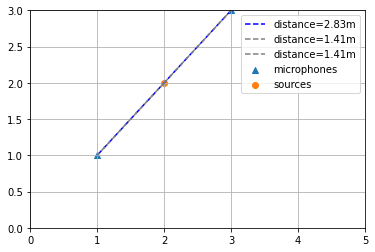

In [22]:
def load_signal(signal_type):
    input_signal, fs = librosa.load("../tests/fixtures/p225_001.wav")

    if signal_type == "noise":
        input_signal, _ = generate_random_source_signal(fs, input_signal.shape[0]/fs, random_gain=False)
    
    return input_signal, fs
    
def simulate_room(input_signal, fs):

    dists = [
        compute_distance(SOURCE_LOCATION, mic_loc)
        for mic_loc in MIC_LOCATIONS
    ]
    
    doa = dists[0] - dists[1]
    tdoa_in_ms = 1000*doa/SPEED_OF_SOUND
    print("Distances: {0:.2f}m, {1:.2f}m. DOA = {2:.2f}m TDOA = {3:.2f}ms".format(
            dists[0], dists[1], doa, tdoa_in_ms))
    room = ConnectedShoeBox(ROOM_DIM, fs=fs)
    room.add_source(SOURCE_LOCATION, input_signal)
    room.add_microphone_array(MIC_LOCATIONS, delay=[0, DELAY])

    simulation_results = simulate(room)
    return simulation_results, room

input_signal, fs = load_signal(SIGNAL_TYPE)

simulated_microphone_signals, room = simulate_room(input_signal, fs)

room_dims = room.dims
mics = room.microphones.get_positions()
sources = [source.loc for source in room.sources.source_array] # TODO: implement get_positions for sources
plot_mics_and_sources(room_dims, mics, sources)
plt.show()

## Autocorrelation comparison between signals

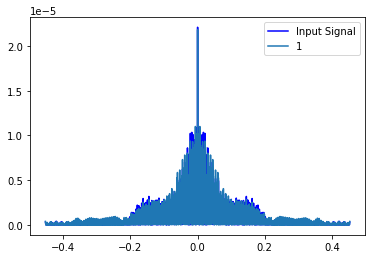

In [33]:
def temporal_cross_correlation(x1, x2, fs):
    
    # Normalize signals for a normalized correlation
    # https://github.com/numpy/numpy/issues/2310
    x1 = (x1 - np.mean(x1)) / (np.std(x1) * len(x1))
    x2 = (x2 - np.mean(x2)) / (np.std(x2) * len(x2))
    
    cc = correlate(x1, x2, mode="same")
    lag_indexes = correlation_lags(x1.shape[0], x2.shape[0], mode="same")

    cc = np.abs(cc)
    
    return cc, lag_indexes/fs


def gcc_phat(x1, x2, fs):
    '''
    This function computes the offset between the signal sig and the reference signal x2
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT) method.
    Implementation based on http://www.xavieranguera.com/phdthesis/node92.html
    '''
    
    n = x1.shape[0] # + x2.shape[0]


    X1 = np.fft.rfft(x1, n=n)
    X2 = np.fft.rfft(x2, n=n)
    R = X1 * np.conj(X2)
    Gphat = R / np.abs(R)
    cc = np.fft.irfft(Gphat, n=n)

    max_shift = n // 2

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))
    
    indxs = np.zeros_like(cc)
    indxs[0:max_shift] = - np.arange(max_shift, 0, -1)
    indxs[max_shift:] = np.arange(0, max_shift + 1)
    indxs = indxs/fs

    return cc, indxs


def cross_correlation(x1, x2, fs, mode=CORRELATION_MODE):
    if mode == "vanilla":
        return temporal_cross_correlation(x1, x2, fs)
    elif mode == "gcc_phat":
        return gcc_phat(x1, x2, fs)


def auto_correlation(x, fs, mode=CORRELATION_MODE):
    return cross_correlation(x, x, fs, mode)


def plot_output_autocorrelation(input_signal, simulated_microphone_signals):

    center = int(input_signal.shape[0]/2)
    autocorrelation, lag_indexes = auto_correlation(input_signal, fs)
    plt.plot(lag_indexes[center-10000:center+10000], autocorrelation[center-10000:center+10000], label="Input Signal", color="b")
    
    center = int(simulated_microphone_signals[0].shape[0]/2)
    for i, signal in enumerate(simulated_microphone_signals):
        if i == 0:
            continue
        autocorrelation, lag_indexes = auto_correlation(signal, fs)
        plt.plot(lag_indexes[center-10000:center+10000], autocorrelation[center-10000:center+10000], label=i) # [22500:23500]
        
    
    
    plt.legend()
    plt.show()
    

plot_output_autocorrelation(input_signal, simulated_microphone_signals)

## TDOA

In [20]:
def compute_tdoa(simulated_microphone_signals, fs):
#     cc, lag_indexes = cross_correlation(simulated_microphone_signals[0],
#                                         simulated_microphone_signals[1],
#                                         fs)
    
    cc, lag_indexes = gcc_phat(simulated_microphone_signals[0],
                               simulated_microphone_signals[0],
                               fs)
    tdoa = lag_indexes[np.argmax(np.abs(cc))]
    
    return tdoa, cc, lag_indexes
    
tdoa, cc, lag_indexes = compute_tdoa(simulated_microphone_signals, fs)
print("TDOA (signal_type={0}): {1:.2f}ms".format(SIGNAL_TYPE, tdoa*1000))


def plot_interval(x, y, fs):
    max_end_secs = (x.shape[0]/fs)/2
    min_start_secs = -max_end_secs
    
    def plot_func(start_secs=min_start_secs, end_secs=max_end_secs):
        start_secs += max_end_secs
        end_secs += max_end_secs
        start = int(start_secs*fs)
        end = int(end_secs*fs)
        x_interval = x[start:end]
        y_interval = y[start:end]
        
        plt.plot(x_interval, y_interval)

    start_slider = FloatSlider(min=min_start_secs, max=max_end_secs, step=0.03, value=min_start_secs)
    end_slider = FloatSlider(min=min_start_secs, max=max_end_secs, step=0.03, value=max_end_secs)

    interact_manual(plot_func,
             start_secs=start_slider,
             end_secs=end_slider)

plot_interval(lag_indexes, cc, fs)

TDOA (signal_type=speech): 0.00ms


interactive(children=(FloatSlider(value=-1.037936507936508, description='start_secs', max=1.037936507936508, m…

## GCC Phat

(46101,)


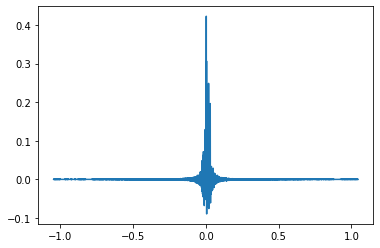

In [5]:

cc, indxs = gcc_phat(simulated_microphone_signals[0], simulated_microphone_signals[1], fs)

print(cc.shape)
plt.plot(indxs, cc)